# Data description & Problem statement: 
This data set contains a total 5820 evaluation scores provided by students from Gazi University in Ankara (Turkey). There is a total of 28 course specific questions and additional 5 attributes. Please check the description at: http://archive.ics.uci.edu/ml/datasets/turkiye+student+evaluation

* Dataset is imbalanced. The data has 5820 rows and 33 variables.
* This is a classification problem. The classification goal is to predict number of times the student is taking this course: 0 (passed) and >0 (failed).

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Cross-validation of Logistic Regression model with L1 regularization
- Cross-validation of Logistic Regression model with L2 regularization
- Use grid-search along with C-V approach to find the best hyperparameters of Logistic Regression model with both L1 & L2 regularizations: Find the best LR model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best LR model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Turkiye student evaluation/turkiye-student-evaluation_generic.csv', sep=',') 


# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head()

,instr,class,nb.repeat,attendance,difficulty,Q1,Q2,Q3,Q4,Q5,...,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28
0,1,10,1,1,4,4,4,3,3,3,...,2,4,3,3,3,3,2,2,1,1
1,2,11,1,1,4,1,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,3,8,2,1,3,3,3,3,3,3,...,3,3,3,3,2,3,3,3,3,4
3,3,13,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,2,6,1,3,2,3,3,4,4,4,...,2,2,3,3,2,2,3,3,4,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5820 entries, 0 to 5819
Data columns (total 33 columns):
instr         5820 non-null int64
class         5820 non-null int64
nb.repeat     5820 non-null int64
attendance    5820 non-null int64
difficulty    5820 non-null int64
Q1            5820 non-null int64
Q2            5820 non-null int64
Q3            5820 non-null int64
Q4            5820 non-null int64
Q5            5820 non-null int64
Q6            5820 non-null int64
Q7            5820 non-null int64
Q8            5820 non-null int64
Q9            5820 non-null int64
Q10           5820 non-null int64
Q11           5820 non-null int64
Q12           5820 non-null int64
Q13           5820 non-null int64
Q14           5820 non-null int64
Q15           5820 non-null int64
Q16           5820 non-null int64
Q17           5820 non-null int64
Q18           5820 non-null int64
Q19           5820 non-null int64
Q20           5820 non-null int64
Q21           5820 non-null int64
Q22      

In [4]:
df['nb.repeat']=df['nb.repeat'].map({1: 0, 2: 1, 3: 1})

In [5]:
#X=df.drop('nb.repeat', axis=1)
X=df[['attendance', 'difficulty', 'class', 'instr']]
y=df['nb.repeat']

In [6]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

encode_text_dummy(X, 'instr')

In [7]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler=MinMaxScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

Max. Lasso score =  0.6693119838602282


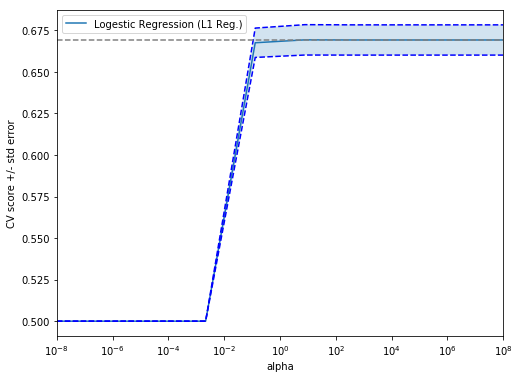

In [9]:
# Cross-Validation for Logestic Regression algorithm: L1 Regularization
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

model = LogisticRegression(penalty='l1', random_state=42)
C = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds=5
kfold= StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for c in C:
    model.C = c
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Lasso score = ", np.max(scores))


plt.figure().set_size_inches(8, 6)
plt.semilogx(C, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(C, scores + std_error, 'b--')
plt.semilogx(C, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(C, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([C[0], C[-1]])
plt.legend(['Logestic Regression (L1 Reg.)'])

Max. Lasso score =  0.6692894658188246


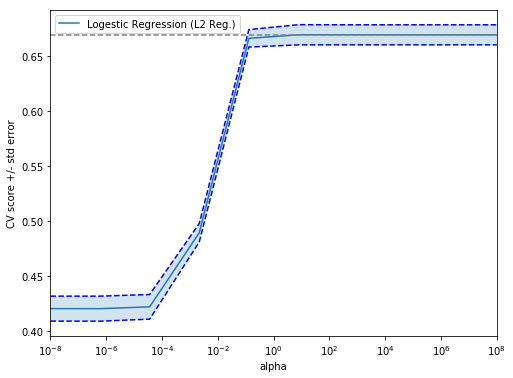

In [10]:
# Cross-Validation for Logestic Regression algorithm: L2 Regularization
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = LogisticRegression(penalty='l2', random_state=42)
C = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds=5
kfold= StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for c in C:
    model.C = c
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Lasso score = ", np.max(scores))

plt.figure().set_size_inches(8, 6)
plt.semilogx(C, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(C, scores + std_error, 'b--')
plt.semilogx(C, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(C, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([C[0], C[-1]])
plt.legend(['Logestic Regression (L2 Reg.)'])

In [30]:
# Grid-Search for the best model parameters: 

from sklearn.model_selection import GridSearchCV

param=[{'penalty':['l2'], 'C': [0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 1000]} ,
       {'penalty':['l1'], 'C': [0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 1000]}]

kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search=GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), param, cv=kfold, scoring="roc_auc")
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,0.007786,0.000429,0.002399,0.001959,10,l2,"{'C': 10, 'penalty': 'l2'}",0.639876,0.684884,0.651361,...,0.669151,0.020471,1,0.680582,0.667577,0.676133,0.670674,0.665816,0.672157,0.005480
14,0.085268,0.013244,0.002411,0.001969,5,l1,"{'C': 5, 'penalty': 'l1'}",0.639876,0.684901,0.651005,...,0.669113,0.020572,2,0.680582,0.667614,0.675498,0.670674,0.666025,0.672078,0.005340
6,0.010079,0.001627,0.000200,0.000399,20,l2,"{'C': 20, 'penalty': 'l2'}",0.639876,0.684884,0.651013,...,0.669112,0.020568,3,0.680582,0.667577,0.675499,0.670674,0.666025,0.672071,0.005346


In [31]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'C': 10, 'penalty': 'l2'}
Best validation accuracy:  0.67 (+/- 0.02)
Test score:  0.7


Confusion matrix, without normalization
[[625 363]
 [ 54 122]]
Normalized confusion matrix
[[0.63 0.37]
 [0.31 0.69]]


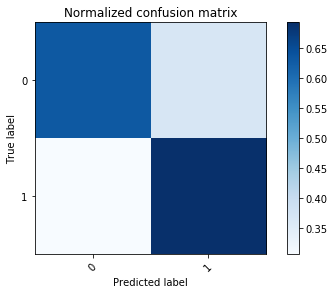

In [32]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [33]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.92      0.63      0.75       988
          1       0.25      0.69      0.37       176

avg / total       0.82      0.64      0.69      1164



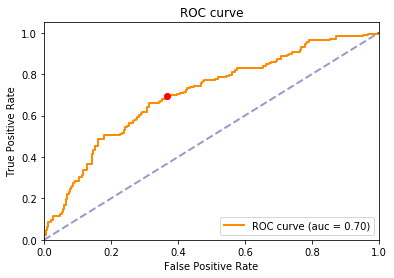

In [34]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

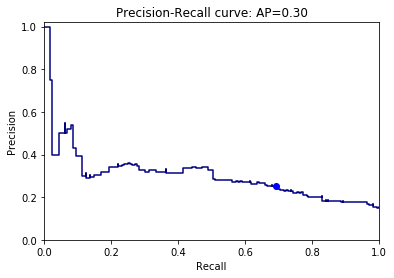

In [35]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(X_test)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(X_test)[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.0])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot(cm_normalized[1,1], cm[1,1]/(cm[1,1]+cm[0,1]), 'ob')
plt.show()

In [36]:
ind=y_test.index
df_X=pd.DataFrame(X_test)
pred=pd.DataFrame(grid_search.predict(X_test))

In [37]:
c=0
L=[]
for i in list(ind):
    if y_test.loc[i]==pred.iloc[c][0] and y_test.loc[i]==1:
        L.append(1)
    elif  y_test.loc[i]!=pred.iloc[c][0] and y_test.loc[i]==1:
        L.append(0)
    c+=1

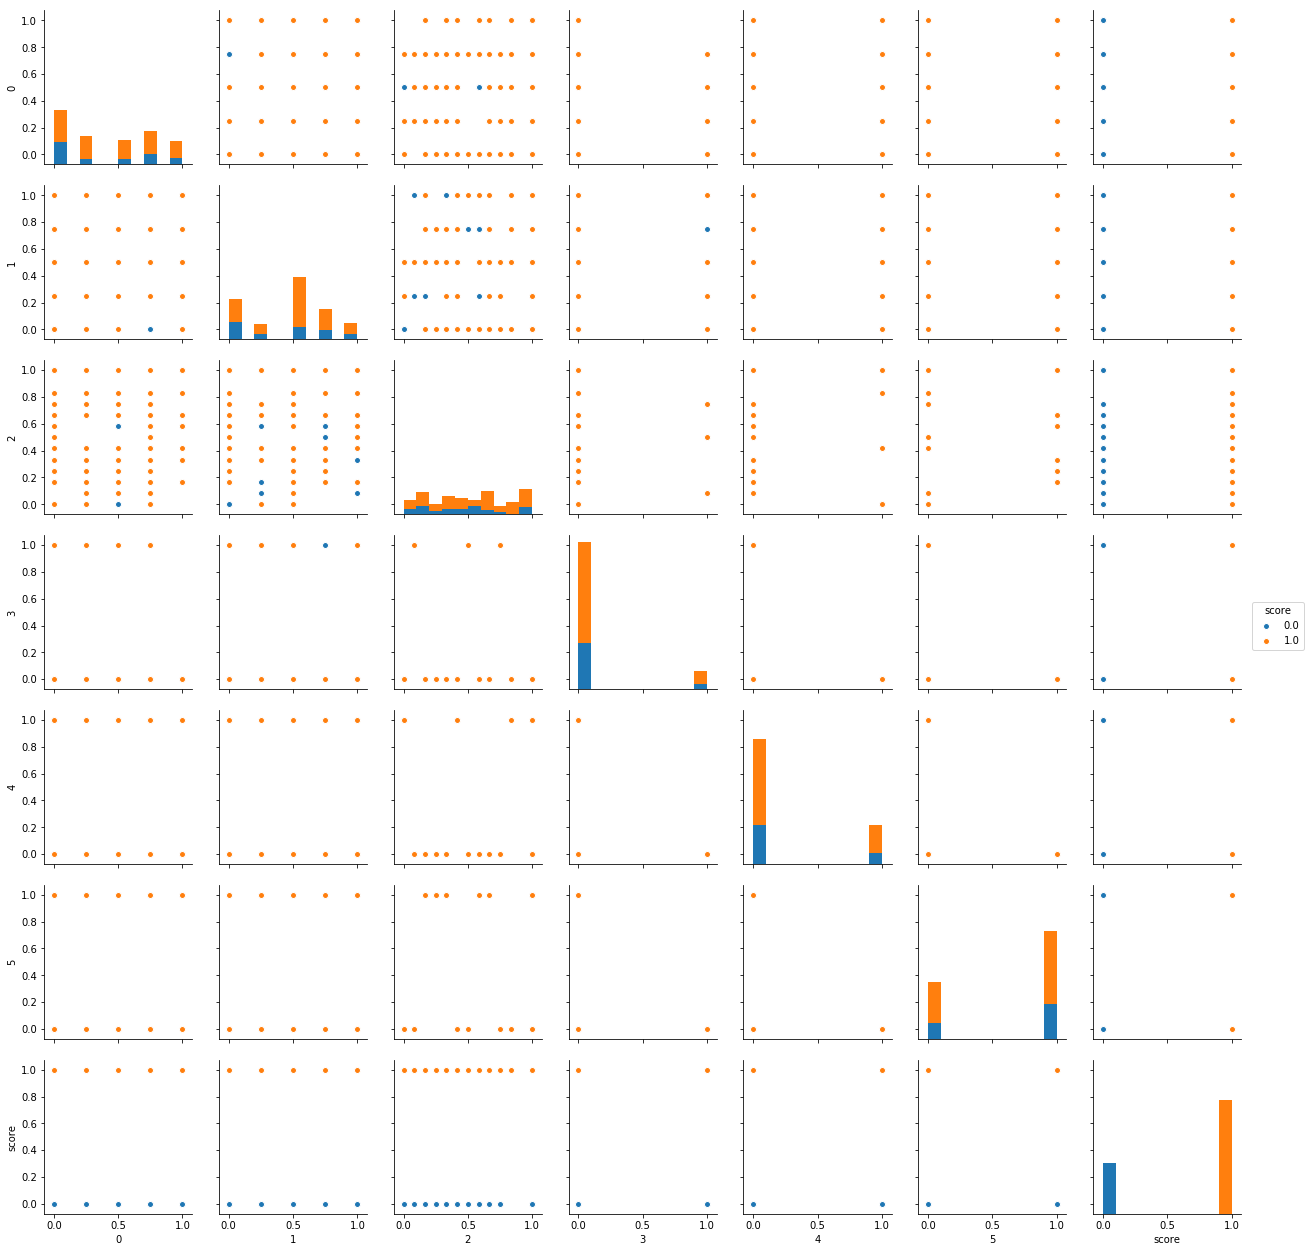

In [38]:
pd.concat([df_X,pd.DataFrame(L, columns=['score'])], axis=1)

sns.pairplot(pd.concat([df_X,pd.DataFrame(L, columns=['score'])], axis=1), hue='score')